# DNN with one hidden layer containing a lot of neurons

In [1]:
import os
#import numpy as np
import sys
import glob
import re
import h5py
#os.environ['KERAS_BACKEND'] = 'theano'
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
#from keras.models import Sequential, Model, model_from_json
#from keras.layers import Dense, Activation, Input, Dense, Dropout, merge, Reshape, Convolution3D, MaxPooling3D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

if __package__ is None:
    sys.path.append(os.path.realpath("/data/shared/Software/CMS_Deep_Learning"))
    
from CMS_Deep_Learning.io import gen_from_data, retrieve_data
from CMS_Deep_Learning.postprocessing.metrics import distribute_to_bins

if __package__ is None:
    sys.path.append(os.path.realpath("/nfshome/vitoriabp/gpu-4-culture-plate-sm/RegressionLCD"))
    
from model import *
from preprocessing import *
from plots import *

Using TensorFlow backend.


# Model

In [2]:
# ECAL input
input1 = Input(shape=(25, 25, 25))
model1 = Flatten()(input1)

#HCAL input
input2 = Input(shape=(5, 5, 60))
model2 = Flatten()(input2)

# Merging inputs
bmodel = merge([model1, model2], mode='concat')

bmodel = (Dense(1280, activation='relu'))(bmodel)

bmodel = (Dropout(0.5))(bmodel)

oe = Dense(1, activation='linear', name='energy')(bmodel)  # output energy regression

# energy regression model
model = Model(input=[input1, input2], output=oe)
model.compile(loss='mse', optimizer='adam')
model.summary()
saveModel(model, name="dnn1")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 25, 25, 25)    0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 5, 5, 60)      0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 15625)         0           input_1[0][0]                    
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 1500)          0           input_2[0][0]                    
___________________________________________________________________________________________

# Train

In [3]:
# Defining the directories, which contain the splitted data

train_dir = "/bigdata/shared/LCD/V1/GammaEscan/train"
valid_dir = "/bigdata/shared/LCD/V1/GammaEscan/valid"
test_dir = "/bigdata/shared/LCD/V1/GammaEscan/test"

## Danny's generator

# training set:
train = gen_from_data(train_dir, batch_size=500, data_keys=[["ECAL", "HCAL"], "target"], prep_func=reshapeData)

# validation set:
val = gen_from_data(valid_dir, batch_size=500, data_keys=[["ECAL", "HCAL"], "target"], prep_func=reshapeData)

# testing set:
test = gen_from_data(valid_dir, batch_size=500, data_keys=[["ECAL", "HCAL"], "target"], prep_func=reshapeData)

# load training data to check
(xe, xh), yt = next(train)
#xe = ecal input (stands for "x, ecal")
#xh = hcal input (stands for "y, hcal")
#yt = energy target (stands for "y, target")

print(xe.shape)
print(xh.shape)
print(yt.shape)

from CMS_Deep_Learning.io import nb_samples_from_h5

tr_samples = nSamples("/bigdata/shared/LCD/V1/GammaEscan/train/")
print(tr_samples)

val_samples = nSamples("/bigdata/shared/LCD/V1/GammaEscan/valid/")
print(val_samples)

(500, 25, 25, 25)
(500, 5, 5, 60)
(500, 1)
399803
100000


In [4]:
hist = model.fit_generator(train, samples_per_epoch=tr_samples, 
                           nb_epoch=50,
                           validation_data = val, 
                           nb_val_samples=val_samples, verbose=1,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min')
                           , ModelCheckpoint(filepath='/nfshome/vitoriabp/gpu-4-culture-plate-sm/CaloImage_DNN/dnn1.h5', verbose=0)]
                            )

Epoch 1/50
399803/399803 [==============================] - 358s - loss: 11398.1459 - val_loss: 179.9329
Epoch 2/50
399803/399803 [==============================] - 352s - loss: 211.1204 - val_loss: 28.7689
Epoch 3/50
399803/399803 [==============================] - 359s - loss: 155.3897 - val_loss: 17.3642
Epoch 4/50
399803/399803 [==============================] - 353s - loss: 146.8199 - val_loss: 14.0899
Epoch 5/50
399803/399803 [==============================] - 359s - loss: 142.8399 - val_loss: 12.8012
Epoch 6/50
399803/399803 [==============================] - 353s - loss: 141.4476 - val_loss: 12.4891
Epoch 7/50
399803/399803 [==============================] - 359s - loss: 140.9816 - val_loss: 12.2708
Epoch 8/50
399803/399803 [==============================] - 352s - loss: 140.9452 - val_loss: 12.2663
Epoch 9/50
399803/399803 [==============================] - 358s - loss: 139.4064 - val_loss: 13.0874
Epoch 10/50
399803/399803 [==============================] - 353s - loss: 139.9

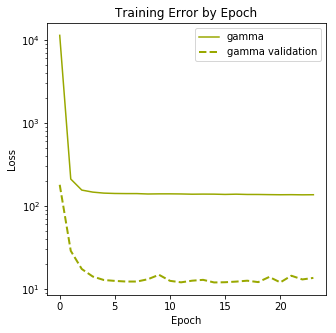

In [5]:
saveLosses(hist, name="dnn")

show_losses([("gamma", hist)])

# Test

In [6]:
if __package__ is None:
    sys.path.append(os.path.realpath("/data/shared/Software/CMS_Deep_Learning"))
    
from CMS_Deep_Learning.io import gen_from_data, retrieve_data, simple_grab
from CMS_Deep_Learning.postprocessing.metrics import distribute_to_bins


if __package__ is None:
    sys.path.append(os.path.realpath("/nfshome/vitoriabp/gpu-4-culture-plate-sm/RegressionLCD"))
    
from model import *
from preprocessing import *
from postprocessing import *

In [7]:
testDir = '/bigdata/shared/LCD/V1/GammaEscan/test/' # test directory with targets
mod = '/nfshome/vitoriabp/gpu-4-culture-plate-sm/CaloImage_DNN/dnn1.json' # model file
w = '/nfshome/vitoriabp/gpu-4-culture-plate-sm/CaloImage_DNN/dnn1.h5' # weights file

from CMS_Deep_Learning.io import simple_grab

# grab y and predictions together
all_y, all_pred, = simple_grab(['Y', 'predictions'], data = testDir, label_keys='target',
                               input_keys=['ECAL', 'HCAL'],
                               model = mod,
                               weights = w)
print all_pred.shape

all_y = all_y[:, 1:]
print(all_y.shape)

#print(all_pred)

#print(all_y)

(289499, 1)
(289499, 1)


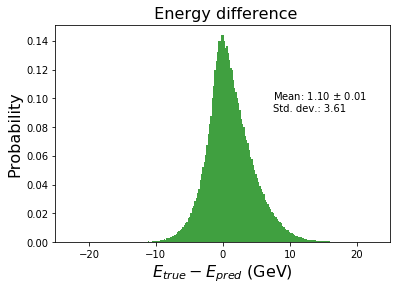

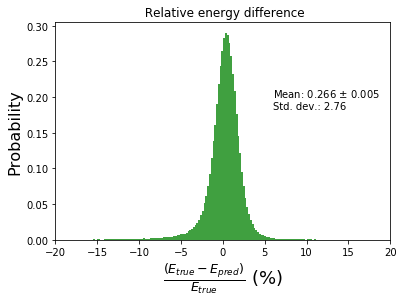

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


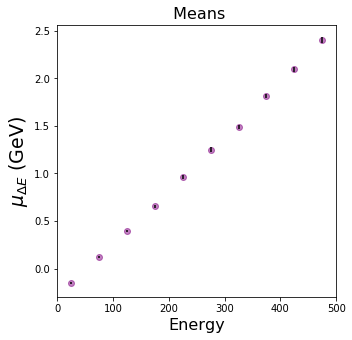

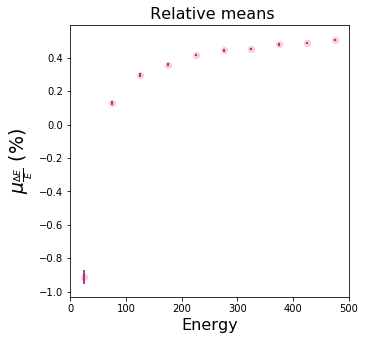

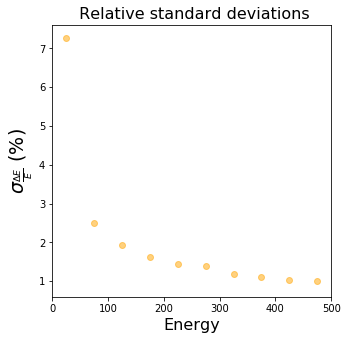

In [8]:
saveTruePred(name="batch_1000_gamma", true=all_y, pred=all_pred)

histEDif(target=all_y, pred=all_pred)

histRelDif(target=all_y, pred=all_pred)

x, y, means, rMeans, stds, rStds, sizes, res = binning(10, all_y.ravel(), all_pred.ravel())

plotN(means, stds, sizes, "means")

plotN(rMeans, rStds, sizes, "rMeans")

plotN(rStds, rStds, sizes, "rStds")